https://www.kaggle.com/code/ashutoshranjan2209/customer-spending-score-prediction

Shop Customer Data is a detailed analysis of a imaginative shop's ideal customers. It helps a business to better understand its customers. The owner of a shop gets information about Customers through membership cards.

kaggle店頭データを用いて、お店の理想的なお客様を検討する<br>
お客様理解にも役に立つし、メンバーシップカードへのインサイトを入手できる<br>
ということで、データセットからよりよい条件が何かを見つけ出し、さいしゅうてきに提案まで結びつける

Customer ID
Gender
Age
Annual Income
Spending Score - Score assigned by the shop, based on customer behavior and spending nature
Profession
Work Experience - in years
Family Size

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
path="/content/Customers.csv"
df=pd.read_csv(path)
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


In [ ]:
df.dropna(inplace=True)
df.shape

(1965, 8)

In [ ]:
df.describe(include='all')

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
count,1965.000000,1965,1965.000000,1965.000000,1965.000000,1965,1965.000000,1965.000000
unique,NaN,2,NaN,NaN,NaN,9,NaN,NaN
top,NaN,Female,NaN,NaN,NaN,Artist,NaN,NaN
freq,NaN,1166,NaN,NaN,NaN,612,NaN,NaN
mean,1000.309924,NaN,48.894656,110616.009669,51.078880,NaN,4.092621,3.757252
std,578.443714,NaN,28.414889,45833.860195,27.977176,NaN,3.926459,1.968335
min,1.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,1.000000
25%,498.000000,NaN,25.000000,74350.000000,28.000000,NaN,1.000000,2.000000
50%,1000.000000,NaN,48.000000,109759.000000,50.000000,NaN,3.000000,4.000000
75%,1502.000000,NaN,73.000000,149095.000000,75.000000,NaN,7.000000,5.000000


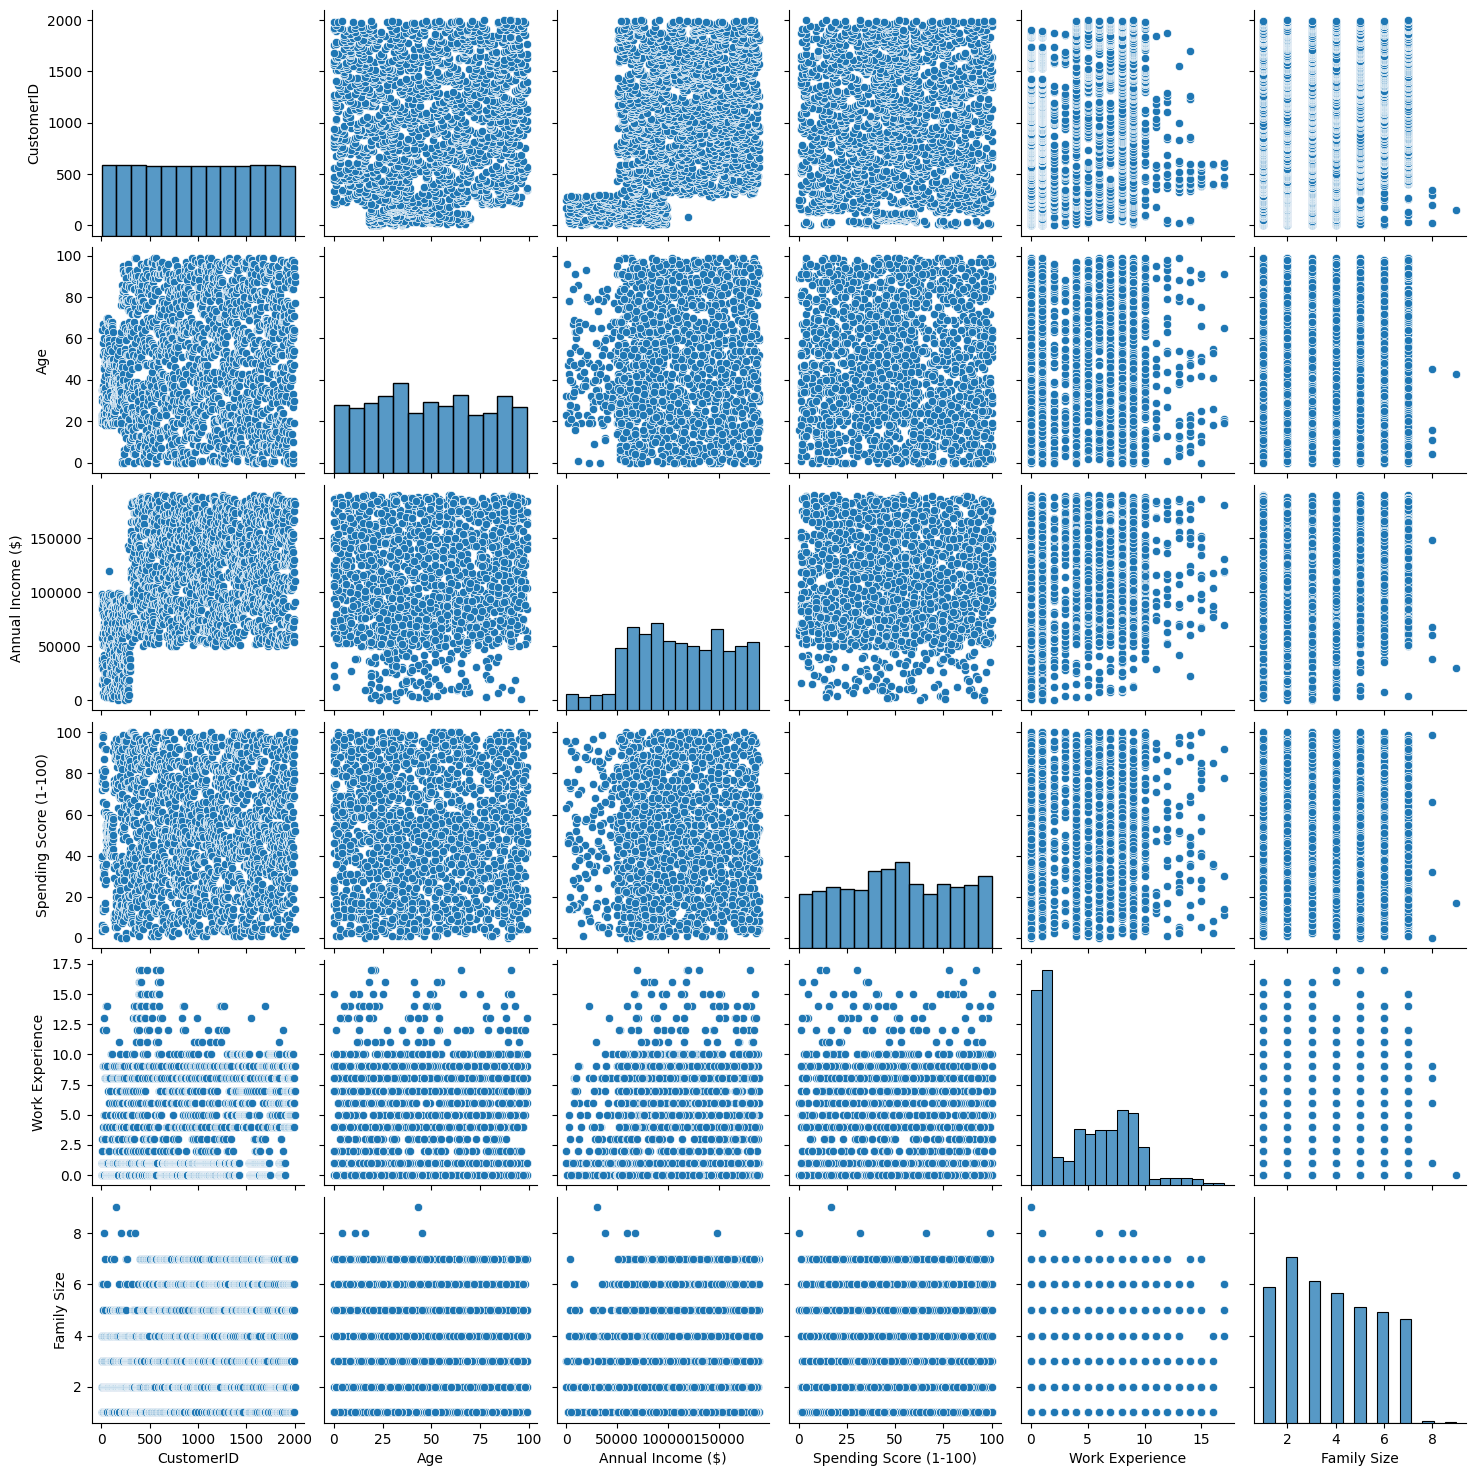

In [ ]:
sns.pairplot(df)

項目でラベルが文字となっているものを、数値化する

In [ ]:
le=LabelEncoder()
df['Gender']=le.fit_transform(df['Gender'])
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,1,19,15000,39,Healthcare,1,4
1,2,1,21,35000,81,Engineer,3,3
2,3,0,20,86000,6,Engineer,1,1
3,4,0,23,59000,77,Lawyer,0,2
4,5,0,31,38000,40,Entertainment,2,6


In [ ]:
le = LabelEncoder()
df['Profession'] = le.fit_transform(df['Profession'])
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,1,19,15000,39,5,1,4
1,2,1,21,35000,81,2,3,3
2,3,0,20,86000,6,2,1,1
3,4,0,23,59000,77,7,0,2
4,5,0,31,38000,40,3,2,6


相関係数行列を求める<br>
正直どこまで強い相関は存在していないような感触

In [ ]:
df.drop(columns='CustomerID').corr()

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
Gender,1.000000,-0.000504,0.004775,0.003703,0.007494,0.017418,-0.002129
Age,-0.000504,1.000000,0.021064,-0.037387,-0.029798,-0.016771,0.034810
Annual Income ($),0.004775,0.021064,1.000000,0.026716,0.015490,0.087135,0.093757
Spending Score (1-100),0.003703,-0.037387,0.026716,1.000000,-0.046437,-0.025587,0.005859
Profession,0.007494,-0.029798,0.015490,-0.046437,1.000000,-0.008619,0.035084
Work Experience,0.017418,-0.016771,0.087135,-0.025587,-0.008619,1.000000,0.012727
Family Size,-0.002129,0.034810,0.093757,0.005859,0.035084,0.012727,1.000000


教師データをy、残りを説明変数Xとする

In [ ]:
y=df['Spending Score (1-100)']
X=df.drop(columns=['CustomerID','Spending Score (1-100)'])

学習、評価にデータ分割

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=0)
print("Training input shape: ", X_train.shape)
print("Training output shape: ", y_train.shape)
print("Testing input shape: ", X_test.shape)
print("Testing output shape: ", y_test.shape)

Training input shape:  (1572, 6)
Training output shape:  (1572,)
Testing input shape:  (393, 6)
Testing output shape:  (393,)


given range on the training set, e.g. between zero and one.<br>
→0～1にサイズをそろえる

In [ ]:
mms=MinMaxScaler()
scaled_X_train=mms.fit_transform(X_train)
scaled_X_test=mms.transform(X_test)
pd.DataFrame(scaled_X_train, columns=X.columns).describe()

,Gender,Age,Annual Income ($),Profession,Work Experience,Family Size
count,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000
mean,0.408397,0.492970,0.582310,0.349237,0.240944,0.388222
std,0.491694,0.288862,0.240482,0.317465,0.227297,0.280080
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.252525,0.391346,0.000000,0.058824,0.142857
50%,0.000000,0.479798,0.581998,0.375000,0.176471,0.428571
75%,1.000000,0.747475,0.784806,0.625000,0.411765,0.571429
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


XG Boostにより推定する

In [ ]:
dtrain=xgb.DMatrix(scaled_X_train, label=y_train)
dtest=xgb.DMatrix(scaled_X_test)

params = {
    'objective': 'reg:squarederror',
    'max_depth': 4,
    'eta': 0.1,
    'subsample': 0.8
}

params['colsample_bytree'] = 0.8
params['gamma'] = 0

num_rounds=500
model_xgb=xgb.train(params, dtrain, num_rounds)

In [ ]:
y_pred_xgb = model_xgb.predict(dtest)
print(f'Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred_xgb))}')

Mean Squared Error: 30.64632049409861


In [ ]:
lr=LinearRegression()
lr.fit(scaled_X_train, y_train)
y_pred_lr=lr.predict(scaled_X_test)
print(f'Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred_lr))}')
print(f'Mean Squared Error: {np.sqrt(mean_squared_error(y_train, lr.predict(scaled_X_train)))}')

Mean Squared Error: 27.781899833367735
Mean Squared Error: 27.938855202722596


各説明変数の影響度を確認。<br>
数値が大きいと影響大きい。<br>
→年齢、年収、職業の順番に影響大きい

In [ ]:
lr.coef_

array([ 0.5773623 , -5.0132362 ,  3.86663792, -3.21053199, -2.15205363,
        1.84784647])

決定係数はあまり大きくない・・・

In [ ]:
lr.score(scaled_X_test, y_test)

-0.00599131575416556